In [1]:
%load_ext autoreload
%autoreload 2

import os
os.environ['KMP_WARNINGS'] = 'off'
import sys
import git

import uproot as ut
import awkward as ak
import numpy as np
import math
import vector
import sympy as sp

import re
from tqdm import tqdm
import timeit
import re

sys.path.append( git.Repo('.', search_parent_directories=True).working_tree_dir )
from utils import *

In [2]:
%load_ext line_profiler
%load_ext memory_profiler

In [3]:
module = fc.eightb.preselection.t8btag_minmass
signal = Tree(module.NMSSM_XYY_YToHH_8b_MX_1000_MY_450)
qcd = Tree(module.Run2_UL18.QCD_B_List)

100%|██████████| 16/16 [00:10<00:00,  1.51it/s]


In [4]:
t8btag = CollectionFilter('jet', filter=lambda t: ak_rank(-t.jet_btag, axis=-1) < 8)
signal = t8btag(signal)
qcd = t8btag(qcd)

In [5]:
trees = ObjIter([signal, qcd])

# Number of Reconstructions

In [6]:
jid = np.arange(8)+1
jid

array([1, 2, 3, 4, 5, 6, 7, 8])

In [7]:
# nCr(8, 2) = 28
h_jid = combinations(8, [2])
h_jid.shape

(28, 1, 2)

In [8]:
# nCr(8, 4) = 70
y_jid = combinations(8, [4])
y_jid.shape

(70, 1, 4)

There are 70 unique groups of 4 (Y). However, since we only have eight jets, each unique Y (group of 4) is paired with exactly one other Y so that all the jets are used

In [9]:
# Number of ways to split 8 jets into 2 groups of 4 jets = 35
yy_jid = combinations(8, [4, 4])
yy_jid.shape

(35, 2, 4)

This means there are 35 unique ways to reconstruct 2 Y's in the event (ignoring pairing higgs)

To reconstruct the higgs we need to include all the combinations inside each Y

In [10]:
# Number of ways to split 4 higgs into 2 groups of 2 higgs = 3
y_hid = combinations(4, [2,2])
y_hid.shape

(3, 2, 2)

Therefore to completely reconstruct the event: X -> 2Y -> 4H -> 8b

There are 35 * 3 * 3 = 315 unique reconstructions


In [11]:
# Number of ways to split 8 jets into 4 groups of 2 jets = 105
quadh_jid = combinations(8, [2, 2, 2, 2])
quadh_jid.shape

(105, 4, 2)

If we ignore the Ys, and try to just reconstruct: X -> 4H -> 8b

There are just 35 * 3 = 105 unque reconstructions

# Ranking Reconstructions

We need to be able to assign some score to each reconstruction to be able to determine the best one

A general form for a ranking can be written as
$$ r_i = R(J, C_i) $$

Where J is a matrix of feature vectors for our jets, such as a stacked P4 vectors of the jets
$$ \text{shape}(J) = 8 \times \text{n features} $$

and $C_i$ is a permutation invariant assignment matrix, which gives a unique reconstruction 
$$ \text{shape}(C_i) = 8 \times 4 $$

The rank for a particular reconstruction should just be a scalar. The best reconstuction for an event is then simply
$$ r = \text{extrema}(r_i) $$
where extrema can be either the minimum or the maximum 

## Closest to Higgs Mass

In [12]:
def closest_to_mass(tree, mass=125):
    jet_p4 = build_p4(tree, 'jet', use_regressed=True)
    def _closest_to_mass_(higgs_index):
        h_jp4 = jet_p4[:, higgs_index]
        h_p4 = h_jp4[:,:,0] + h_jp4[:,:,1]
        h_dm = np.sqrt( ak.sum( (h_p4.m - mass)**2, axis=1 ) )
        return h_dm
    quadh_rank = ak_stack([ _closest_to_mass_(jid) for jid in tqdm(quadh_jid) ], axis=1)
    best_rank, best_arg = ak.min(quadh_rank, axis=1), ak.argmin(quadh_rank, axis=1)
    best_comb = ak.from_regular(quadh_jid[best_arg], axis=1)
    build_all_dijets(tree, best_comb, ordered='pt')
    tree.extend(quadh_rank=best_rank)
    
trees.apply(closest_to_mass);

100%|██████████| 105/105 [01:12<00:00,  1.45it/s]


100%|██████████| 4/4 [00:01<00:00,  2.58it/s]


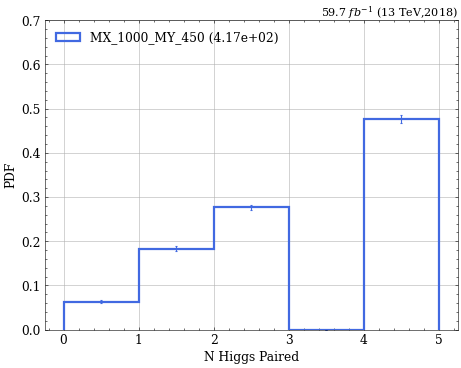

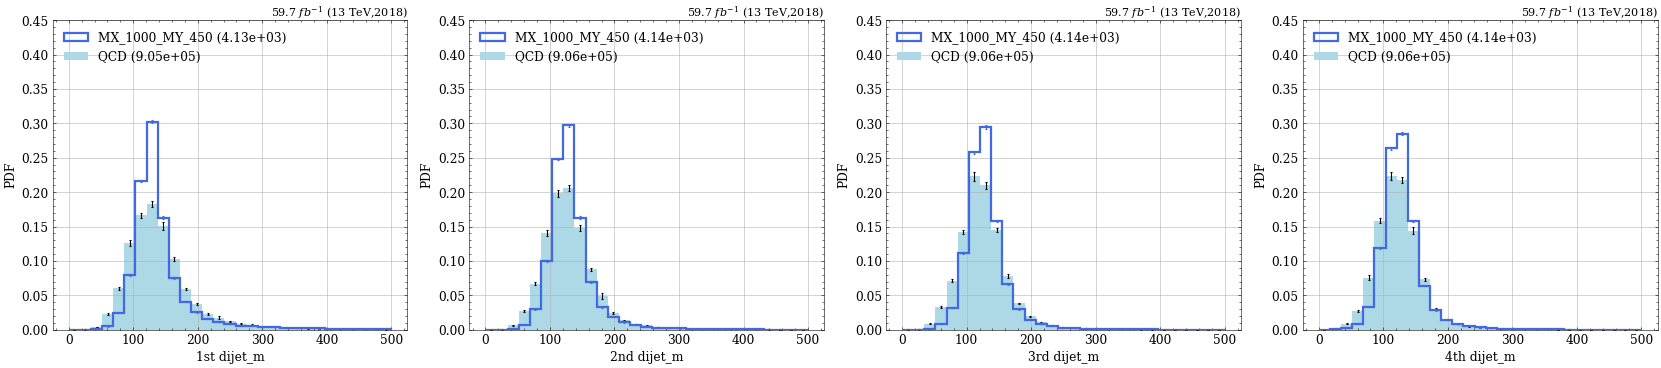

In [13]:
study.quick( 
    [signal],
    masks=lambda t : t.nfound_select==8,
    legend=True,
    efficiency=True,
    varlist=[lambda t : ak.sum(t.dijet_signalId>-1, axis=-1)],
    xlabels=['N Higgs Paired'],
    ylim=(0,0.7), grid=True,
    dim=-1,
)

study.quick( 
    trees,
    legend=True,
    efficiency=True,
    varlist=[f'dijet_m[:,{i}]' for i in range(4)],
    binlist=[(0,500,30)]*4,
    ylim=(0,0.45), grid=True,
    dim=-1,

)

Due to the large combinatorics involved, we can see that even in background we find a strong higgs mass peak in all 4 dijet masses

## Minimum Mass Asymmetry

In [14]:
def min_mass_asym(tree, mass=125):
    jet_p4 = build_p4(tree, 'jet', use_regressed=True)
    def _min_mass_asym_(higgs_index):
        h_jp4 = jet_p4[:, higgs_index]
        h_p4 = h_jp4[:,:,0] + h_jp4[:,:,1]
        h1_m, h2_m = ak.unzip(ak.combinations(h_p4.m, n=2, axis=1))
        asym = (h1_m-h2_m)/(h1_m+h2_m)
        h_dm = np.sqrt( ak.sum( asym**2, axis=1 ) )
        return h_dm
    quadh_rank = ak_stack([ _min_mass_asym_(jid) for jid in tqdm(quadh_jid) ], axis=1)
    best_rank, best_arg = ak.min(quadh_rank, axis=1), ak.argmin(quadh_rank, axis=1)
    best_comb = ak.from_regular(quadh_jid[best_arg], axis=1)
    build_all_dijets(tree, best_comb, ordered='pt')
    tree.extend(quadh_rank=best_rank)
    
trees.apply(min_mass_asym);

100%|██████████| 105/105 [01:16<00:00,  1.37it/s]


100%|██████████| 4/4 [00:00<00:00, 16.72it/s]


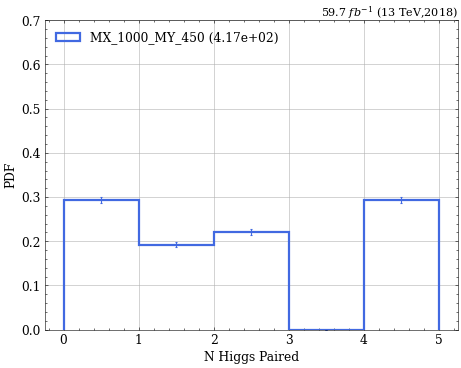

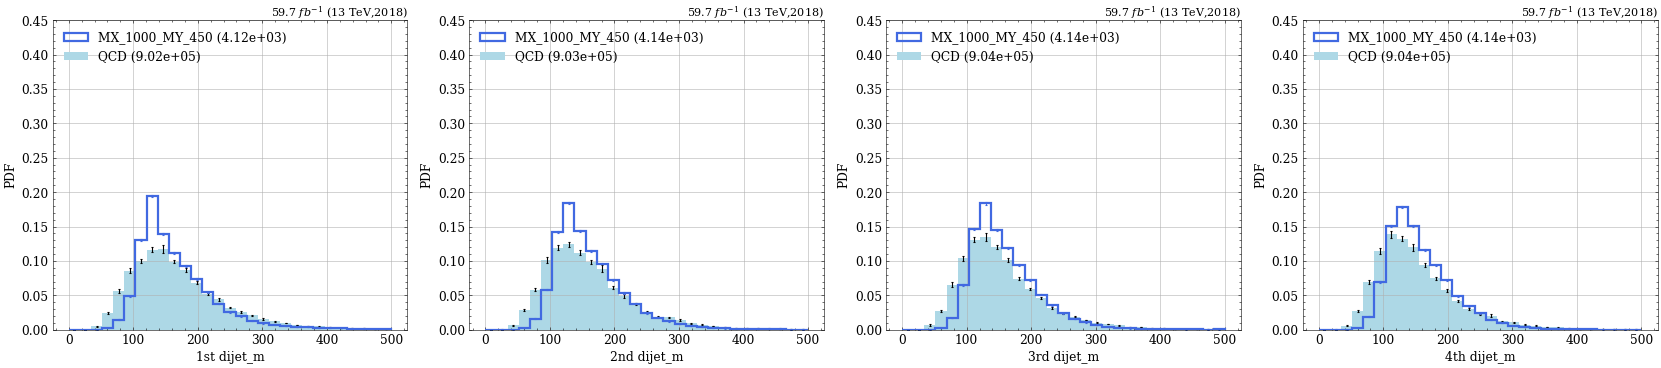

In [15]:
study.quick( 
    [signal],
    masks=lambda t : t.nfound_select==8,
    legend=True,
    efficiency=True,
    varlist=[lambda t : ak.sum(t.dijet_signalId>-1, axis=-1)],
    xlabels=['N Higgs Paired'],
    ylim=(0,0.7), grid=True,
    dim=-1,
)

study.quick( 
    trees,
    legend=True,
    efficiency=True,
    varlist=[f'dijet_m[:,{i}]' for i in range(4)],
    binlist=[(0,500,30)]*4,
    ylim=(0,0.45), grid=True,
    dim=-1,

)

Since there are lot of correlations between all 8 jets, we can try to train a neural network to predict these ranks 

# Machine Learned Ranking

The goal of this network is to predict the ranking function
$$ r_i = R(J, C_i) $$

For signal events (with all 8 higgs jets), the most natural rank is the number of correctly assigned jets

Therefore for each event, there are N different unique reconstructions (using N in place of 105 or 315 depending on which reconstruction we are interested in ranking)

And each reconstruction has a different number of correctly assigned jets that we want the network to predict

An advantage of predicting the ranks, instead of classifying the correct reconstuction, may allow the network to learn partial reconstuctions (instead of all or nothing)

Using the results of the network are also very simple, since all we need to do is take the maximum scoring reconstruction as the result for each event

## Signal Ranked Machine Learned Ranking

In [16]:
basepath = '/uscms_data/d3/ekoenig/8BAnalysis/studies/weaver-multiH/weaver/models'
ranker_path = f'{basepath}/quadh_ranker_mp/20221209_b72001172c5d04183ed7bb294252320b_ranger_lr0.0047_batch1024_m7m10m12_withbkg/'

trees.apply(lambda t : eightb.load_quadh(t, ranker_path, name='dijet'), report=True)

100%|██████████| 2/2 [00:04<00:00,  2.19s/it]


[None, None]

100%|██████████| 4/4 [00:00<00:00, 14.18it/s]


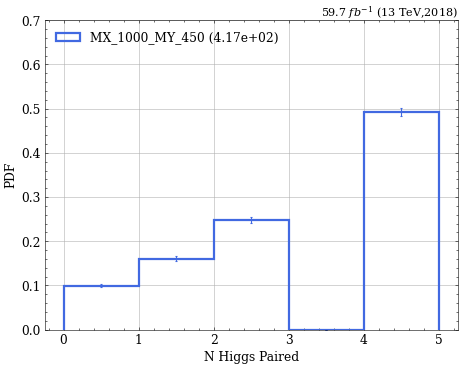

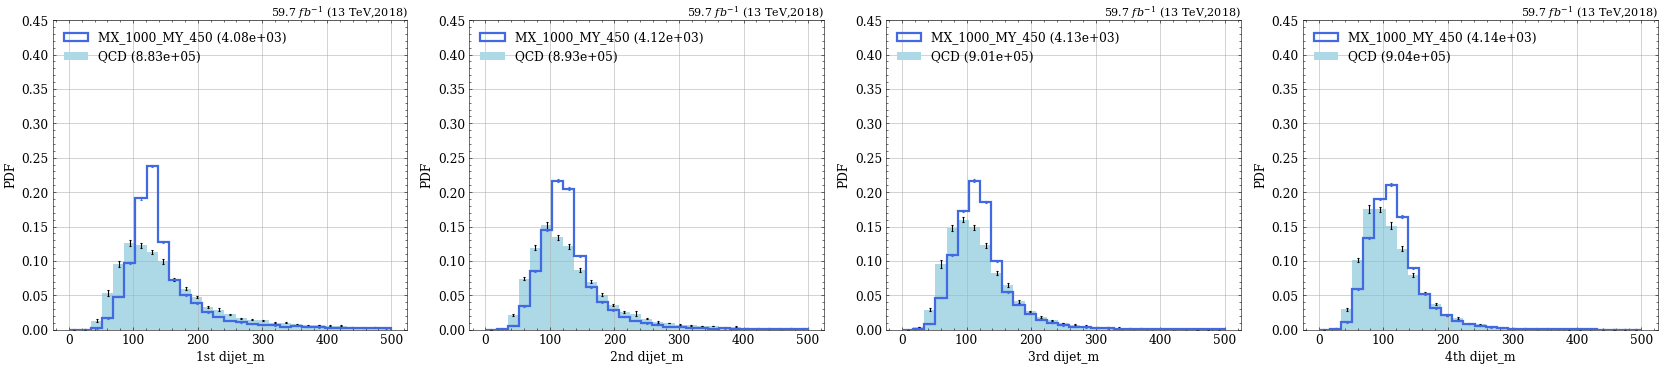

In [17]:
study.quick( 
    [signal],
    masks=lambda t : t.nfound_select==8,
    legend=True,
    efficiency=True,
    varlist=[lambda t : ak.sum(t.dijet_signalId>-1, axis=-1)],
    xlabels=['N Higgs Paired'],
    ylim=(0,0.7), grid=True,
    dim=-1,
)

study.quick( 
    trees,
    legend=True,
    efficiency=True,
    varlist=[f'dijet_m[:,{i}]' for i in range(4)],
    binlist=[(0,500,30)]*4,
    ylim=(0,0.45), grid=True,
    dim=-1,

)

Since this network is only trained on signal, we can see that it has been able to reconstruct the higgs mass in the background.

We would like the background shape to be as flat as possible, so we need to train with background to be able to tell the network to not depend on the higgs mass 

To do this we can train with background ranked by the number of dijets with mass outside the higgs mass

That way the network will be punished for ranking reconstructions based soley on the higgs mass 

We can add this background ranking goal, controlled by a hyper parameter
$$ \text{Total Loss} = \text{Loss(Signal N Higgs Paired)} + \lambda\cdot\text{Loss(Bkg N Dijets outside }M_H) $$

## Signal + Bkg Ranked Machine Learned Ranking

In [18]:
basepath = '/uscms_data/d3/ekoenig/8BAnalysis/studies/weaver-multiH/weaver/models'
ranker_path = f'{basepath}/quadh_ranker_mp/20221209_be9efb5b61eb1c42aeb209728eec84d7_ranger_lr0.0047_batch1024_m7m10m12_withbkg/'

trees.apply(lambda t : eightb.load_quadh(t, ranker_path, name='dijet'), report=True)

100%|██████████| 2/2 [00:04<00:00,  2.19s/it]


[None, None]

100%|██████████| 4/4 [00:00<00:00, 14.71it/s]


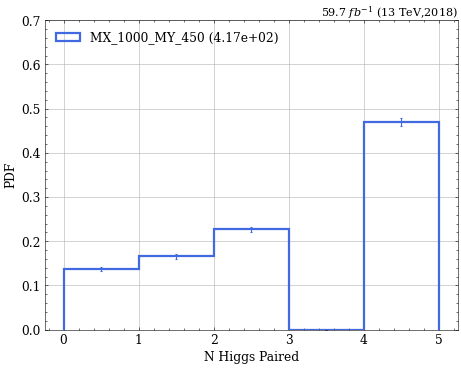

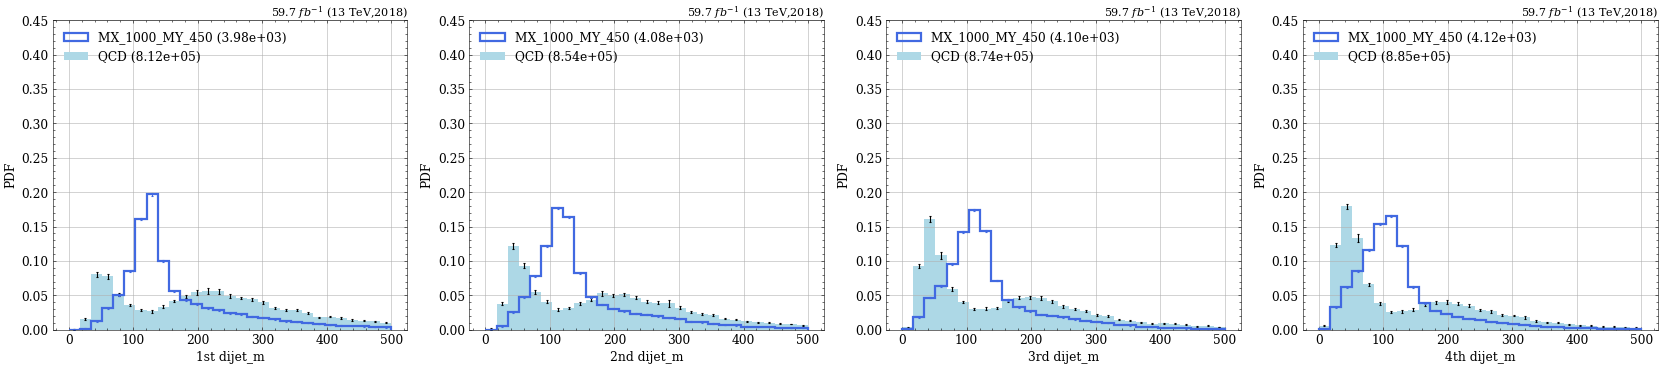

In [19]:
study.quick( 
    [signal],
    masks=lambda t : t.nfound_select==8,
    legend=True,
    efficiency=True,
    varlist=[lambda t : ak.sum(t.dijet_signalId>-1, axis=-1)],
    xlabels=['N Higgs Paired'],
    ylim=(0,0.7), grid=True,
    dim=-1,
)

study.quick( 
    trees,
    legend=True,
    efficiency=True,
    varlist=[f'dijet_m[:,{i}]' for i in range(4)],
    binlist=[(0,500,30)]*4,
    ylim=(0,0.45), grid=True,
    dim=-1,

)

We can see that we can shape the background easily based on the ranking function we choose to predict. 

While still reconstructing a higgs peak in the signal.

This freedom is not easily achieved with pure mass based ranking 

# Graphs

In [20]:
import networkx as nx

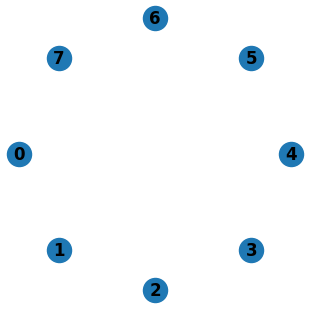

In [49]:
G = nx.Graph()
G.add_nodes_from(np.arange(8))

# for edge in quadh_jid[55]:
#     G.add_edge(*edge)

plt.figure(figsize=(3,3)) 
nx.draw_shell(G, with_labels=True, font_weight='bold')

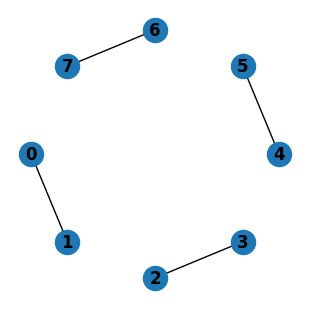

In [50]:
G = nx.Graph()
G.add_nodes_from(np.arange(8))

for edge in quadh_jid[0]:
    G.add_edge(*edge)
    
plt.figure(figsize=(3,3)) 
nx.draw_shell(G, with_labels=True, font_weight='bold')

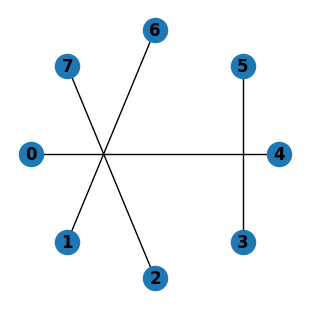

In [51]:
G = nx.Graph()
G.add_nodes_from(np.arange(8))

for edge in quadh_jid[56]:
    G.add_edge(*edge)
    
plt.figure(figsize=(3,3)) 
nx.draw_shell(G, with_labels=True, font_weight='bold')

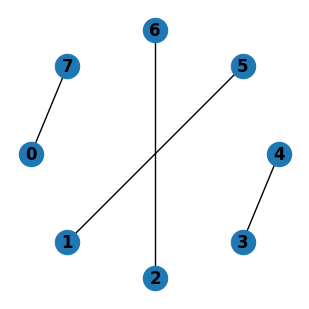

In [52]:
G = nx.Graph()
G.add_nodes_from(np.arange(8))

for edge in quadh_jid[101]:
    G.add_edge(*edge)
    
plt.figure(figsize=(3,3)) 
nx.draw_shell(G, with_labels=True, font_weight='bold')